In [6]:
import numpy as np
import matplotlib.pyplot as plt

def initialize_lattice(size):
    # Create a 2D array 'lattice' of dimensions size x size, initialized to 0
    lattice = np.zeros((size, size), dtype=int)
    return lattice

def compute_neighbor_indices(size):
    # Create an empty dictionary to store neighbor indices
    neighbor_indices = {}
    
    # Loop over each cell in the lattice
    for x in range(size):
        for y in range(size):
            # Calculate the neighbors with periodic boundary conditions
            neighbors = [
                ((x - 1) % size, y),   # Left neighbor
                ((x + 1) % size, y),   # Right neighbor
                (x, (y - 1) % size),   # Top neighbor
                (x, (y + 1) % size)    # Bottom neighbor
            ]
            # Store neighbors for each position in the dictionary
            neighbor_indices[(x, y)] = neighbors
            
    return neighbor_indices

def calculate_interaction_energy(lattice, site, particle, neighbor_indices, epsilon_AA, epsilon_BB, epsilon_AB):
    # Extract the coordinates of the site
    x, y = site
    # Initialize interaction energy
    interaction_energy = 0

    # Iterate over each neighbor of the site
    for neighbor in neighbor_indices[(x, y)]:
        neighbor_particle = lattice[neighbor]
        
        # If there's a particle at the neighboring site
        if neighbor_particle != 0:
            if particle == 1:  # Particle A
                if neighbor_particle == 1:
                    interaction_energy += epsilon_AA
                else:  # Neighbor is Particle B
                    interaction_energy += epsilon_AB
            else:  # Particle B
                if neighbor_particle == 2:
                    interaction_energy += epsilon_BB
                else:  # Neighbor is Particle A
                    interaction_energy += epsilon_AB
                    
    return interaction_energy

import numpy as np

def attempt_move(lattice, N_A, N_B, N_empty, neighbor_indices, params):
    # Extract lattice size and parameters
    size = lattice.shape[0]
    N_sites = size * size
    beta = 1 / params['T']
    epsilon_A = params['epsilon_A']
    epsilon_B = params['epsilon_B']
    epsilon_AA = params['epsilon_AA']
    epsilon_BB = params['epsilon_BB']
    epsilon_AB = params['epsilon_AB']
    mu_A = params['mu_A']
    mu_B = params['mu_B']

    # Decide whether to add or remove a particle
    if np.random.rand() < 0.5:  # Attempt to add a particle
        if N_empty == 0:
            return N_A, N_B, N_empty  # No empty sites available

        # Select a random empty site
        empty_sites = np.argwhere(lattice == 0)
        site = tuple(empty_sites[np.random.randint(len(empty_sites))])

        # Decide which particle to add
        if np.random.rand() < 0.5:
            particle = 1  # Particle A
            mu = mu_A
            epsilon = epsilon_A
            N_s = N_A
        else:
            particle = 2  # Particle B
            mu = mu_B
            epsilon = epsilon_B
            N_s = N_B

        # Calculate the change in energy
        delta_E = epsilon + calculate_interaction_energy(lattice, site, particle, neighbor_indices, epsilon_AA, epsilon_BB, epsilon_AB)
        acc_prob = min(1, (N_empty / (N_s + 1)) * np.exp(-beta * (delta_E - mu)))

        # Attempt the move based on acceptance probability
        if np.random.rand() < acc_prob:
            lattice[site] = particle
            if particle == 1:
                N_A += 1
            else:
                N_B += 1
            N_empty -= 1

    else:  # Attempt to remove a particle
        if N_sites - N_empty == 0:
            return N_A, N_B, N_empty  # No particles to remove

        # Select a random occupied site
        occupied_sites = np.argwhere(lattice != 0)
        site = tuple(occupied_sites[np.random.randint(len(occupied_sites))])
        particle = lattice[site]

        # Set parameters based on particle type
        if particle == 1:
            mu = mu_A
            epsilon = epsilon_A
            N_s = N_A
        else:
            mu = mu_B
            epsilon = epsilon_B
            N_s = N_B

        # Calculate the change in energy
        delta_E = -epsilon - calculate_interaction_energy(lattice, site, particle, neighbor_indices, epsilon_AA, epsilon_BB, epsilon_AB)
        acc_prob = min(1, (N_s / (N_empty + 1)) * np.exp(-beta * (delta_E + mu)))

        # Attempt the move based on acceptance probability
        if np.random.rand() < acc_prob:
            lattice[site] = 0  # Remove particle
            if particle == 1:
                N_A -= 1
            else:
                N_B -= 1
            N_empty += 1

    return N_A, N_B, N_empty

import numpy as np

def run_simulation(size, n_steps, params):
    # Initialize lattice and neighbor indices
    lattice = initialize_lattice(size)
    neighbor_indices = compute_neighbor_indices(size)
    N_sites = size * size

    # Initialize particle counts and empty site count
    N_A = 0
    N_B = 0
    N_empty = N_sites

    # Arrays to store coverage over time
    coverage_A = np.zeros(n_steps)
    coverage_B = np.zeros(n_steps)

    # Run the simulation for the specified number of steps
    for step in range(n_steps):
        # Attempt a move and update counts
        N_A, N_B, N_empty = attempt_move(lattice, N_A, N_B, N_empty, neighbor_indices, params)
        
        # Calculate coverage and store it
        coverage_A[step] = N_A / N_sites
        coverage_B[step] = N_B / N_sites

    return lattice, coverage_A, coverage_B



def plot_lattice(lattice, ax, title):
    size = lattice.shape[0]
    
    # Loop through the lattice to plot particles
    for x in range(size):
        for y in range(size):
            if lattice[x, y] == 1:
                # Plot a red circle for Particle A
                ax.plot(x + 0.5, y + 0.5, 'o', color='red', markersize=6)
            elif lattice[x, y] == 2:
                # Plot a blue circle for Particle B
                ax.plot(x + 0.5, y + 0.5, 'o', color='blue', markersize=6)
    
    # Set axis limits and labels
    ax.set_xlim(0, size)
    ax.set_ylim(0, size)
    ax.set_xticks(np.arange(0, size + 1, 1))
    ax.set_yticks(np.arange(0, size + 1, 1))
    ax.set_xticklabels([])  # Hide x-axis labels
    ax.set_yticklabels([])  # Hide y-axis labels
    
    # Set the grid to show the major ticks for clearer grid lines
    ax.grid(which='major', linestyle='-', color='black', linewidth=0.5)
    
    # Set the title of the plot
    ax.set_title(title)
    
    return ax




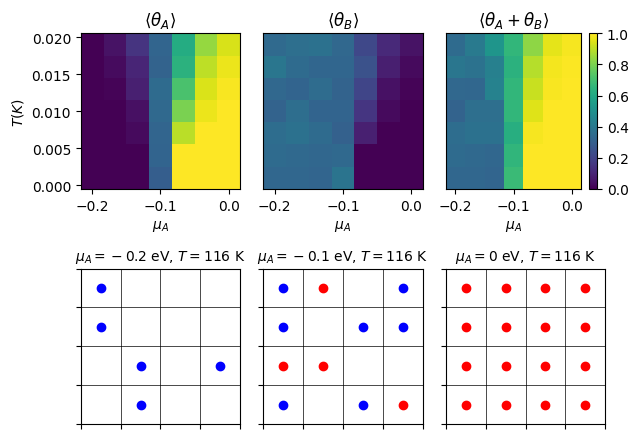

In [9]:
import numpy as np
import matplotlib.pyplot as plt


# Parameters
size = 4
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7)
Ts = np.linspace(0.001, 0.019, 7)
params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1,
            'epsilon_B': -0.1,
            'epsilon_AA': 0,
            'epsilon_BB': 0,
            'epsilon_AB': 0,
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k)
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_A = np.zeros((len(mus_A), len(Ts)))
mean_coverage_B = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_A, coverage_B = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_A[i // len(Ts), i % len(Ts)] = np.mean(coverage_A[-1000:])
    mean_coverage_B[i // len(Ts), i % len(Ts)] = np.mean(coverage_B[-1000:])

# Plot the T-mu_A phase diagram
fig, axs = plt.subplot_mosaic([[0, 1, 2], [3, 4, 5]], figsize=(6.5, 4.5))
#fig, axs = plt.subplots(2, 3, figsize=(6.5, 4.5))

# Mean coverage of A
axs[0].pcolormesh(mus_A, Ts, mean_coverage_A.T, cmap='viridis', vmin=0, vmax=1)
axs[0].set_title(r'$\langle \theta_A \rangle$')
axs[0].set_xlabel(r'$\mu_A$')
axs[0].set_ylabel(r'$T(K)$')

# Mean coverage of B
axs[1].pcolormesh(mus_A, Ts, mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[1].set_title(r'$\langle \theta_B \rangle$')
axs[1].set_xlabel(r'$\mu_A$')
axs[1].set_yticks([])

# Mean total coverage
cax = axs[2].pcolormesh(mus_A, Ts, mean_coverage_A.T + mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[2].set_title(r'$\langle \theta_A + \theta_B \rangle$')
axs[2].set_xlabel(r'$\mu_A$')
axs[2].set_yticks([])
fig.colorbar(cax, ax=axs[2], location='right', fraction=0.1)

# Plot the final lattice configuration

fontisize=10
# mu_A = -0.2 eV and T = 0.01 / k
axs[3] = plot_lattice(final_lattice[0, 3], axs[3], r'$\mu_A = -0.2$ eV, $T = 116$ K')
axs[3].set_title(r'$\mu_A = -0.2$ eV, $T = 116$ K', fontsize=fontisize)

# mu_A = -0.1 eV and T = 0.01 / k
axs[4] = plot_lattice(final_lattice[3, 3], axs[4], r'$\mu_A = -0.1$ eV, $T = 116$ K')
axs[4].set_title(r'$\mu_A = -0.1$ eV, $T = 116$ K', fontsize=fontisize)

# mu_A = 0 eV and T = 0.01 / k
axs[5] = plot_lattice(final_lattice[6, 3], axs[5], r'$\mu_A = 0$ eV, $T = 116$ K')
axs[5].set_title(r'$\mu_A = 0$ eV, $T = 116$ K', fontsize=fontisize)

plt.tight_layout()
plt.show()

